In [117]:
!pip install smogn

In [118]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.autograd import Variable
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import r2_score
from sklearn.model_selection import ParameterGrid
import smogn

# 데이터셋 불러오기
df = pd.read_csv('/content/drive/MyDrive/deep_learning/Final_Project/data.csv')

In [119]:
# 범주형 열을 인코딩
encoder = LabelEncoder()
df['structure_encoded'] = encoder.fit_transform(df['structure'])
df['category_encoded'] = encoder.fit_transform(df['category'])

# 특징과 타겟 정의
X = df.drop(['name', 'log_breakdown_field', 'structure', 'category'], axis=1)
y = df['log_breakdown_field'].values

In [120]:
# 학습 및 테스트 데이터 분리
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# 데이터프레임 형태로 변환 (smogn을 사용하기 위해 필요)
train_df = X_train.copy()
train_df['log_breakdown_field'] = y_train

# SMOTER 적용
train_df_smote = smogn.smoter(data=train_df.reset_index(drop=True), y='log_breakdown_field')

# 증강된 데이터를 다시 분리
X_train_smote = train_df_smote.drop(columns=['log_breakdown_field'])
y_train_smote = train_df_smote['log_breakdown_field'].values

# 검증 및 테스트 데이터 분리
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 데이터 정규화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 텐서로 변환
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_smote, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# TensorDataset과 DataLoader 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

r_index: 100%|##########| 3/3 [00:00<00:00, 63.58it/s]


In [121]:
# 다층 퍼셉트론 모델 정의
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, (hidden_dim // 2))
        self.layer3 = nn.Linear((hidden_dim // 2), output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# 하이퍼파라미터 그리드 설정
param_grid = {
    'hidden_dim': [16, 32, 64],
    'dropout_rate': [0.3, 0.5, 0.7],
    'learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [16, 32, 64]
}

# 하이퍼파라미터 튜닝 함수
def hyperparameter_tuning(param_grid):
    best_r2 = -float('inf')
    best_params = None

    for params in ParameterGrid(param_grid):
        input_dim = X_train_tensor.shape[1]
        hidden_dim = params['hidden_dim']
        output_dim = 1
        dropout_rate = params['dropout_rate']
        learning_rate = params['learning_rate']
        batch_size = params['batch_size']

        model = MLP(input_dim, hidden_dim, output_dim, dropout_rate)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # 학습
        patience = 10
        best_val_loss = float('inf')
        patience_counter = 0
        epochs = 1000

        for epoch in range(epochs):
            model.train()
            train_loss = 0.0

            for input, target in train_loader:
                y_train_pred = model(input)
                loss = criterion(y_train_pred, target)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            train_loss /= len(train_loader)

            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for input, target in val_loader:
                    y_val_pred = model(input)
                    loss = criterion(y_val_pred, target)
                    val_loss += loss.item()

            val_loss /= len(val_loader)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                break

        # 모델 평가
        val_r2, _, _ = evaluation(model, val_loader)
        if val_r2 > best_r2:
            best_r2 = val_r2
            best_params = params

    return best_params, best_r2

# 모델 평가 함수
def evaluation(model, dataloader):
    predictions = torch.tensor([], dtype=torch.float32)
    actual = torch.tensor([], dtype=torch.float32)
    model.eval()

    with torch.no_grad():
        for inputs, targets in dataloader:
            y_test_pred = model(inputs)
            predictions = torch.cat((predictions, y_test_pred), 0)
            actual = torch.cat((actual, targets), 0)

    predictions = predictions.numpy()
    actual = actual.numpy()
    r2 = r2_score(actual, predictions)
    return r2, predictions, actual

In [122]:
# 하이퍼파라미터 튜닝 실행
best_params, best_r2 = hyperparameter_tuning(param_grid)
print(f"best_params : {best_params}, best_r2, {best_r2}")

# 최적의 하이퍼파라미터로 최종 모델 학습 및 평가
input_dim = X_train_tensor.shape[1]
hidden_dim = best_params['hidden_dim']
output_dim = 1
dropout_rate = best_params['dropout_rate']
learning_rate = best_params['learning_rate']
batch_size = best_params['batch_size']

model = MLP(input_dim, hidden_dim, output_dim, dropout_rate)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

best_params : {'batch_size': 32, 'dropout_rate': 0.5, 'hidden_dim': 16, 'learning_rate': 0.01}, best_r2, 0.8526204982194021


In [123]:
model

MLP(
  (layer1): Linear(in_features=10, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=8, bias=True)
  (layer3): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [124]:
# 학습
patience = 10
best_val_loss = float('inf')
patience_counter = 0
epochs = 1000

train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    for input, target in train_loader:
        y_train_pred = model(input)
        loss = criterion(y_train_pred, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for input, target in val_loader:
            y_val_pred = model(input)
            loss = criterion(y_val_pred, target)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    if (epoch + 1) % 25 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}")

    # 조기 종료 조건 확인
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

Epoch 25/1000, Train Loss: 2.909, Val Loss: 2.106
Epoch 50/1000, Train Loss: 1.084, Val Loss: 1.073
Early stopping at epoch 56


In [125]:
train_r2, _, _ = evaluation(model, train_loader)
val_r2, _, _ = evaluation(model, val_loader)
test_r2, test_predictions, test_actual = evaluation(model, test_loader)

print(f"Train R2: {train_r2:.3f}")
print(f"Validation R2: {val_r2:.3f}")
print(f"Test R2: {test_r2:.3f}")

Train R2: 0.806
Validation R2: 0.347
Test R2: 0.765


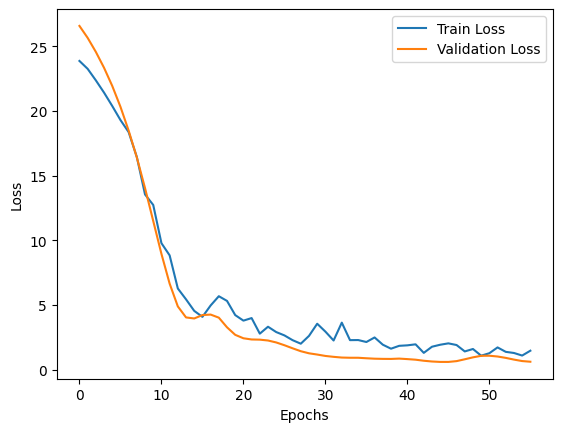

In [126]:
# 학습 및 검증 손실 시각화
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [128]:
## Define a helper function for plotting
from sklearn.metrics import r2_score

y_category = df.loc[X_test.index, 'category'].values

def result_plot(y_test, y_pred, y_category):
    ## Calculate R^2 score
    r2 = r2_score(y_test, y_pred)

    ## Calculate error
    error = y_test - y_pred
    y_test_with_errors = pd.DataFrame({
        'Actual': y_test.flatten(),
        'Predicted': y_pred.flatten(),
        'Error': error.flatten(),
        'Category': y_category[:len(y_test)]
    })

    ## Plotting with R^2 score and error distribution
    fig, axs = plt.subplots(2, 1, figsize=(8, 14))
    sns.scatterplot(x='Actual', y='Predicted', hue='Category', style='Category', data=y_test_with_errors, ax=axs[0])
    axs[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--k')
    axs[0].set_xlabel('True Values')
    axs[0].set_ylabel('Predicted Values')
    axs[0].set_title(f'Predicted vs Actual Values\nR2 Score: {r2:.2f}')
    axs[0].legend(title='Category')

    sns.boxplot(x='Category', y='Error', hue='Category', data=y_test_with_errors, ax=axs[1], palette='tab10')
    axs[1].set_xlabel('Category')
    axs[1].set_ylabel('Errors')
    axs[1].set_title('Errors by Category')
    axs[1].tick_params(axis='x', rotation=45)
    axs[1].axhline(y=0, color='black', linestyle='--', linewidth=1.5)
    plt.tight_layout()
    plt.show()

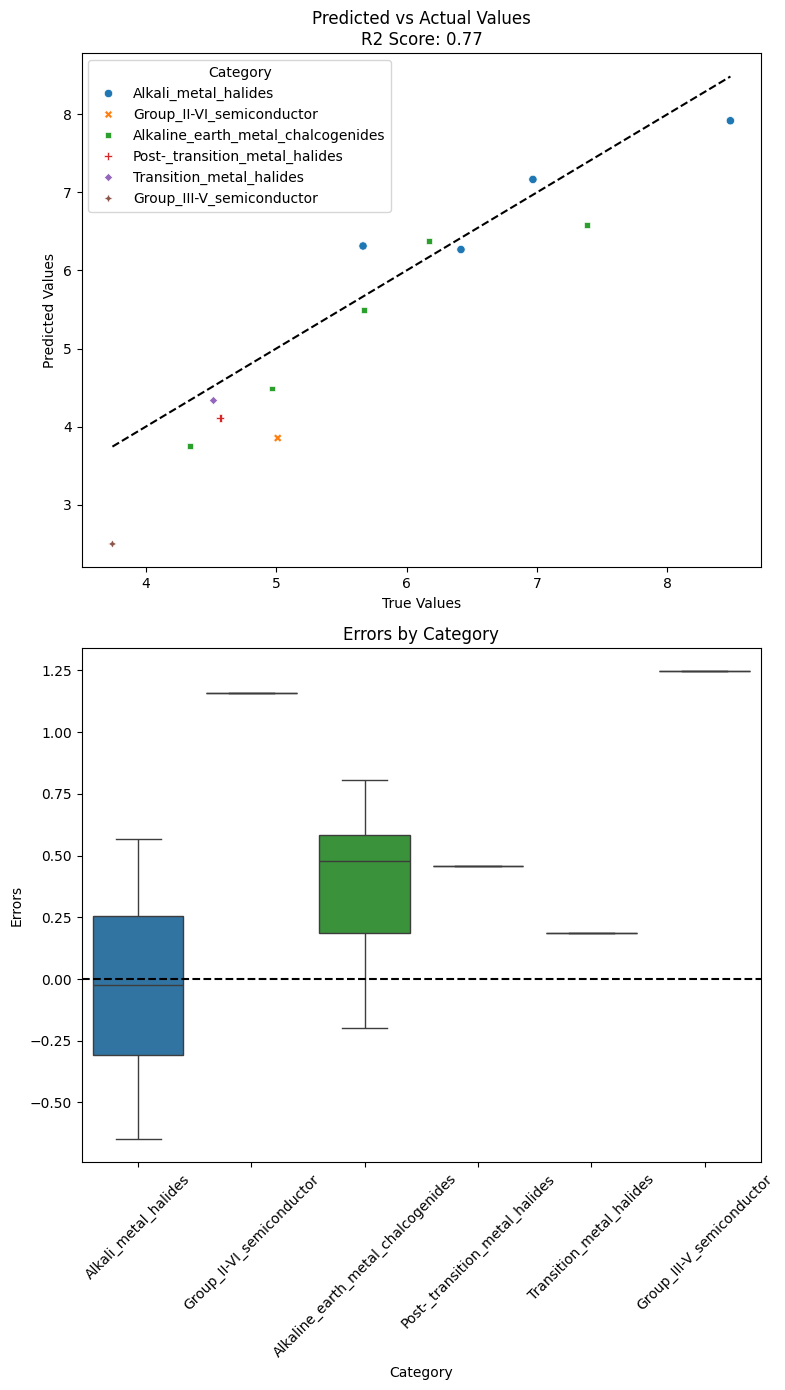

In [129]:
result_plot(test_actual, test_predictions, y_category)

In [131]:
# 교차 검증을 위한 훈련 데이터 및 검증 데이터 인덱스 생성
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 모든 폴드에서의 평가 지표 및 예측값 초기화
train_r2_list = []
val_r2_list = []
test_predictions_list = []
test_actual_list = []

# 교차 검증을 통한 모델 학습 및 평가
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_scaled, y_train_smote), 1):
    print(f"Fold {fold}")

    # 훈련 데이터 및 검증 데이터를 DataLoader로 변환
    train_fold_dataset = TensorDataset(X_train_tensor[train_idx], y_train_tensor[train_idx])
    val_fold_dataset = TensorDataset(X_train_tensor[val_idx], y_train_tensor[val_idx])
    train_fold_loader = DataLoader(train_fold_dataset, batch_size=batch_size, shuffle=True)
    val_fold_loader = DataLoader(val_fold_dataset, batch_size=batch_size, shuffle=False)

    # 모델 초기화 및 최적화기 및 손실 함수 정의
    model = MLP(input_dim, hidden_dim, output_dim, dropout_rate)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # 최적의 모델을 찾기 위한 조기 종료를 위한 변수 초기화
    best_val_loss = float('inf')
    patience_counter = 0

    # 훈련 및 검증 과정
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for input, target in train_fold_loader:
            y_train_pred = model(input)
            loss = criterion(y_train_pred, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_fold_loader)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for input, target in val_fold_loader:
                y_val_pred = model(input)
                loss = criterion(y_val_pred, target)
                val_loss += loss.item()

        val_loss /= len(val_fold_loader)

        # 조기 종료 조건 확인
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # 각 폴드에서의 최적의 모델로 평가
    train_r2, _, _ = evaluation(model, train_fold_loader)
    val_r2, _, _ = evaluation(model, val_fold_loader)
    test_r2, test_predictions, test_actual = evaluation(model, test_loader)

    # 평가 지표 및 예측값 저장
    train_r2_list.append(train_r2)
    val_r2_list.append(val_r2)
    test_predictions_list.append(test_predictions)
    test_actual_list.append(test_actual)

    print(f"Train R2: {train_r2:.3f}")
    print(f"Validation R2: {val_r2:.3f}")
    print(f"Test R2: {test_r2:.3f}")
    print("="*50)

# 평균 R2 값 출력
print("Average Train R2:", np.mean(train_r2_list))
print("Average Validation R2:", np.mean(val_r2_list))

# 모든 폴드에서의 테스트 R2 값 출력
for fold, test_r2 in enumerate(test_r2_list, 1):
    print(f"Fold {fold} Test R2:", test_r2)

Fold 1
Early stopping at epoch 81
Train R2: 0.844
Validation R2: 0.872
Test R2: 0.581
Fold 2
Early stopping at epoch 95
Train R2: 0.880
Validation R2: 0.804
Test R2: 0.765
Fold 3
Early stopping at epoch 71
Train R2: 0.881
Validation R2: 0.848
Test R2: 0.563
Fold 4
Early stopping at epoch 58
Train R2: 0.771
Validation R2: -0.056
Test R2: 0.017
Fold 5
Early stopping at epoch 41
Train R2: 0.736
Validation R2: 0.724
Test R2: 0.326
Average Train R2: 0.8223537802600625
Average Validation R2: 0.6381966014773918


NameError: name 'test_r2_list' is not defined